## 2D ultrasound propagation with a planar circular transducer (Yanagita et al. 2009)

## Objectives

- Implement an ultrasound propagation based on Yanagita et al. 2009
- Model the acoustic pressure distribution along the fiber.
- Run simulations of the fiber model with various inputs, and describe results. 
- Check the dependence of the maximum stimulation amplitude on the distance to the transducer.
- Compute a strength-distance curve (threshold excitation amplitude as a function of distance to transducer) for a stimulus of a given duration.
- Compute a strength-duration curve for the transducer at a given distance.
- Find out which parameters could be validated during the experiments.

### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from PySONIC.utils import logger, si_format
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import PlanarDiskTransducerSource
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve

## Acoustic propagation from a planar transducer

Acoustic propagation is implemented as in Yanagita et al. 2009, based on the Rayleigh–Sommerfeld integral solution for a 1D case.

The key idea of the paper is to calculate the acoustic pressure in the observation points based on the acoustic pressure of the transducer surface. The transducer surface velocity is assumed to be continuous.

### Acoustic source: planar disk transducer

Let's define a planar disk transducer at a given 2D location to represent our acoustic source.

In [5]:
u_z = 1                          # transducer surface velocity (m/s)
c = 1490.0                       # medium speed of sound (m/s) as in Yanagita et al.
rho = 1e3                        # medium density (kg/m3)
r_tr = (2.54e-3) / 2             # transducer radius (m)
x0 = 0                           # transducer location x-axis (m)
z0 = 0                           # transducer location z-axis (m)
freqs = [0.5e6, 1e6, 2e6, 5e6]   # US frequencies
fref = freqs[0]
psources = {Fdrive: PlanarDiskTransducerSource(x0, z0, Fdrive, rho=rho, c=c, r=r_tr) for Fdrive in freqs}

### Transducer approximation with point sources

Let's test different way to model the circular transducer with point sources: sunflower, quadratic and concentric circles methods.

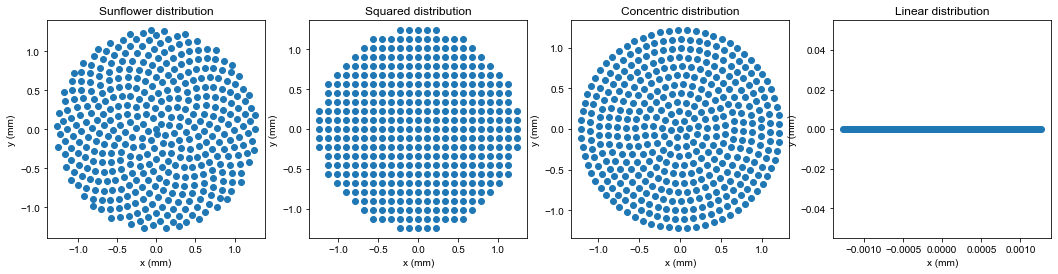

In [6]:
m = 400            # Number of point sources

# Simulate the point sources distributions    
xs, ys = psources[fref].DPSM_sunflowersources(m)    # Sunflower
xq, yq = psources[fref].DPSM_squaredsources(m)      # Squared
xc, yc = psources[fref].DPSM_concentricsources(m)   # Concentric
xl, yl = psources[fref].DPSM_linearsources(m)       # Linear
# Plot the point sources distributions
fig, axes = plt.subplots(1, 4, figsize=(18,4))
ax = axes[0]
ax.set_title('Sunflower distribution')
ax.plot(xs * 1e3, ys * 1e3,'o')
ax = axes[1]
ax.set_title('Squared distribution')
ax.plot(xq * 1e3, yq * 1e3,'o')
ax = axes[2]
ax.set_title('Concentric distribution')
ax.plot(xc * 1e3, yc * 1e3,'o')
ax = axes[3]
ax.set_title('Linear distribution')
ax.plot(xl,yl,'o')
for ax in axes:
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')

# Simulate the US amplitude along normal axis
n = 400   # Number of samples in x, z
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m

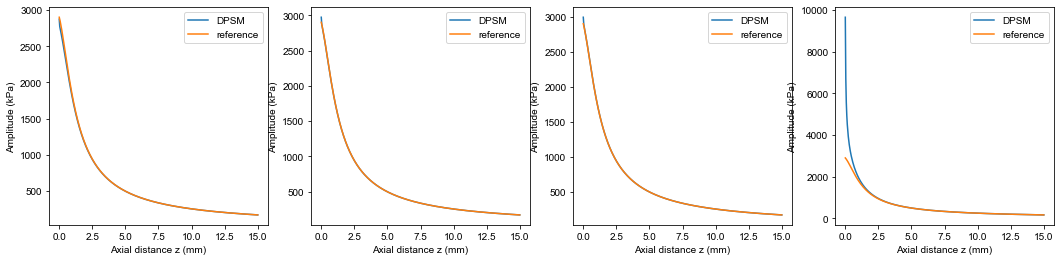

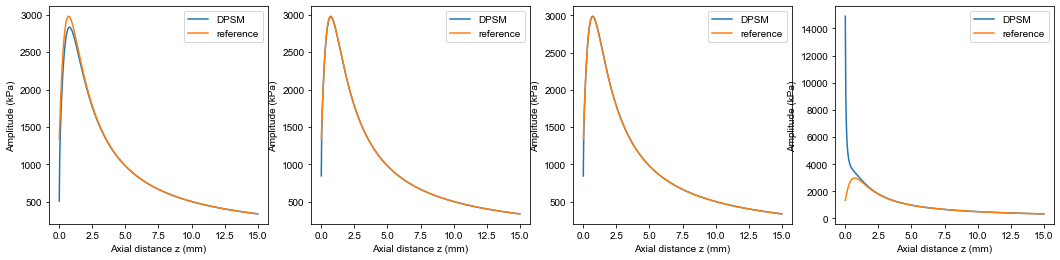

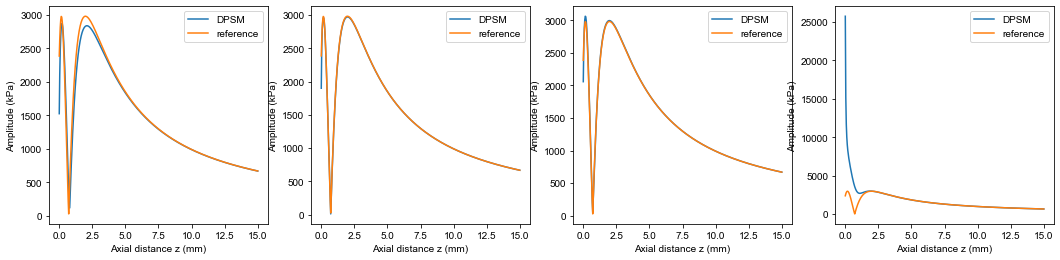

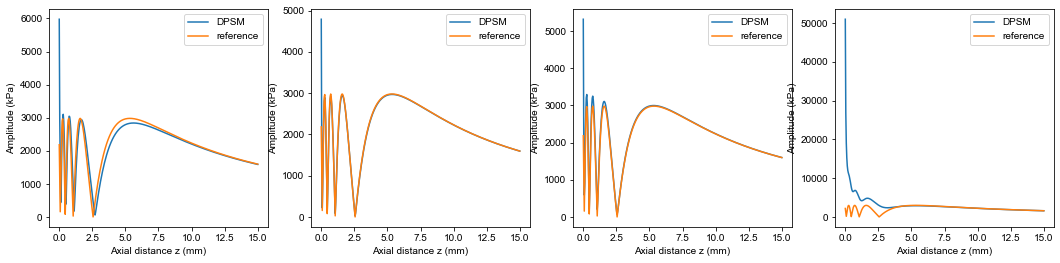

In [7]:
for freq, psource in psources.items():
    
    refamps = psource.normalAxisAmp (z, u_z)
    
    samps = psource.DPSM (x, z, u_z, m, 'sunflower')
    qamps = psource.DPSM (x, z, u_z, m, 'squared')
    camps = psource.DPSM (x, z, u_z, m, 'concentric')
    lamps = psource.DPSM (x, z, u_z, m, 'linear')
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    ax = axes[0]
    ax.plot(z * 1e3, samps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    ax = axes[1]
    ax.plot(z * 1e3, qamps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    ax = axes[2]
    ax.plot(z * 1e3, camps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    ax = axes[3]
    ax.plot(z * 1e3, lamps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    for ax in axes:
        ax.set_xlabel('Axial distance z (mm)')
        ax.set_ylabel('Amplitude (kPa)')
        ax.legend()

### Comparison of different point sources distributions

Compare the resulting acoustic fields along the z direction (the only one for which we have an analitical solution) varying the number of point sources and the frequency of stimulation.

In [ ]:
# Definition  of the cost function
# Standard deviation from the reference amplitude (along z)
def sd (x, z, amps, refamps):
    return np.sqrt( sum((amps[int(x.size / 2), :] - refamps)**2) / (len(z)-1)) 

# Calculation of the cost function of the 3 point sources distributions for different m-f combination
mmin = 100
mmax = 1900
mvalues = 10
mtest = np.linspace(mmin, mmax, mvalues)
sds = np.zeros((mvalues, len(freqs)))
sdq = np.zeros((mvalues, len(freqs)))
sdc = np.zeros((mvalues, len(freqs)))
for j, freq in enumerate(freqs):
    refamps = psources[freq].normalAxisAmp (z, u_z)
    for i, m in enumerate(mtest):
        samps = psources[freq].DPSM (x, z, u_z, m, 'sunflower')
        qamps = psources[freq].DPSM (x, z, u_z, m, 'squared')
        camps = psources[freq].DPSM (x, z, u_z, m, 'concentric')
        sds[i, j] = sd (x, z, samps, refamps)
        sdq[i, j] = sd (x, z, qamps, refamps)
        sdc[i, j] = sd (x, z, camps, refamps)
    print(j)
print('end')

0
1


In [ ]:
colors = plt.get_cmap('tab20c').colors

def test_sdm(freqs, mtest, sds, sdq, sdc):
    fig, axes = plt.subplots(1, len(freqs), figsize=(18, 4))
    for j, f in enumerate(freqs):
        ax = axes[j]
        ax.set_title(f'freq = {si_format(freqs[j])}Hz') 
        ax.plot(mtest, sds[:,j] * 1e-3, label='sunflower', color=colors[0])
        ax.plot(mtest, sdq[:,j] * 1e-3, label='squared', color=colors[4])
        ax.plot(mtest, sdc[:,j] * 1e-3, label='concentric', color=colors[8])
        ax.set_xlabel('Number of point sources')
        ax.set_ylabel('SD (kPa)')
        ax.legend()
    fig.suptitle('Comparison between our approximation and the analitical solution varying type of distribution, m, f', fontsize=15)
    return fig

def test_sdf(freqs, mvector, sds, sdq, sdc):
    fig, axes = plt.subplots(1, len(mvector), figsize=(18, 4))
    f = np.array(freqs) * 1e-3
    for i, m in enumerate(mvector):
        ax = axes[i]
        ax.set_title(f'm = {mvector[i]:.0f}') 
        ax.plot(f, sds[i,:] * 1e-3, label='sunflower', color=colors[0])
        ax.plot(f, sdq[i,:] * 1e-3, label='squared', color=colors[4])
        ax.plot(f, sdc[i,:] * 1e-3, label='concentric', color=colors[8])
        ax.set_xlabel('Freq (MHz)')
        ax.set_ylabel('SD (kPa)')
        ax.legend()
    return fig

def plot_mf(mvector, freqs, sds, sdq, sdc):
    plt.figure(figsize=(16,10))
    for j, f in enumerate(freqs):
        plt.plot(mtest, sds[:,j] * 1e-3, label=f'sunflower, f = {si_format(f)}Hz', color=colors[j])
        plt.plot(mtest, sdq[:,j] * 1e-3, label=f'squared, f = {si_format(f)}Hz', color=colors[4+j])
        plt.plot(mtest, sdc[:,j] * 1e-3, label=f'concentric, f = {si_format(f)}Hz', color=colors[8+j])
    plt.legend()
    plt.xlabel('Number of point sources', size=13)
    plt.ylabel('SD (kPa)', size=13)
    return fig
    
fig = test_sdm(freqs, mtest, sds, sdq, sdc)
mvector = [mtest[0], mtest[3], mtest[6], mtest[9]]
fig = test_sdf(freqs, mvector, sds, sdq, sdc)
fig = plot_mf(mvector, freqs, sds, sdq, sdc)

- The number of point sources at which we reach the convergence is approximately 1500.
- Increasing the frequency increase also the error.

### 2D acoustic field

Let's compute the 2D acoustic pressure distribution generated by the transducer:

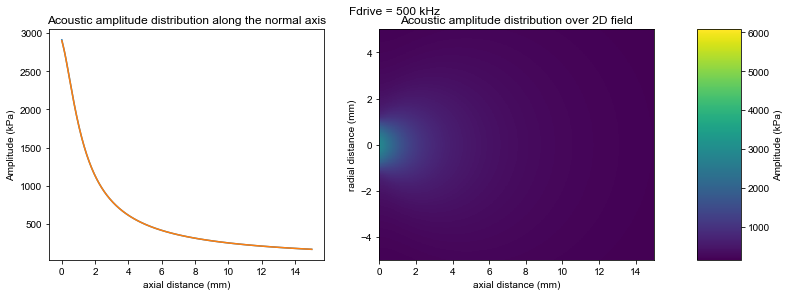

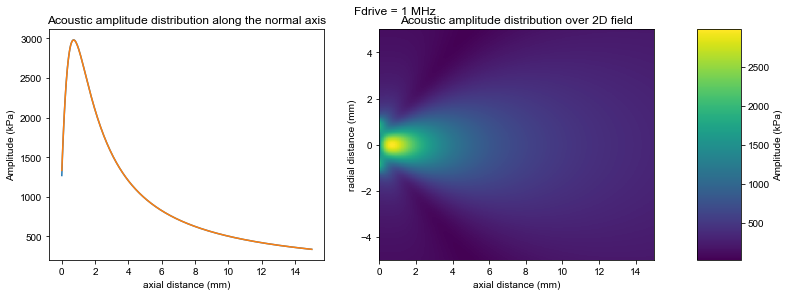

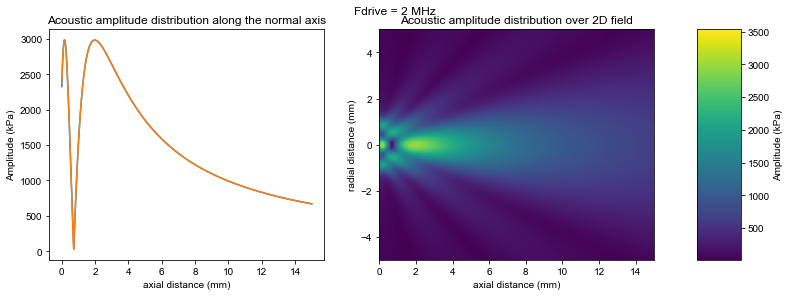

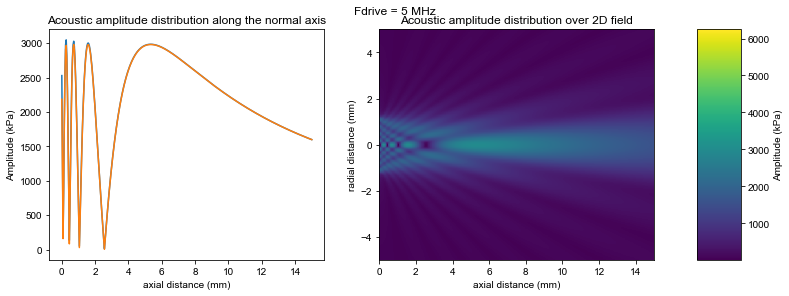

In [17]:
def plotAmpDist(x, z, amps, refamps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax.plot(z * 1e3, refamps * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='viridis')
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    return fig

# Generate 2D square grid
n = 400
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m
xx, zz = np.meshgrid(x, z)

m = 1500   # number of point sources at which we reach convergence

# Plot acoustic amplitudes over 2D grid for each frequency
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM (x, z, u_z, m, 'concentric')  # Pa
    refamps = psources[Fdrive].normalAxisAmp (z, u_z)
    fig = plotAmpDist(x, z, amps, refamps)
    fig.suptitle(f'Fdrive = {si_format(Fdrive)}Hz', fontsize=12)

### Acoustic distribution along fiber

Let's check how the resulting acoustic pressure distribution along the different nodes of a fiber placed orthogonally to the acoustic propagation axis.

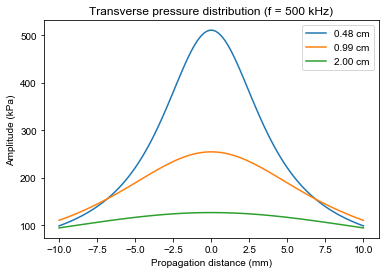

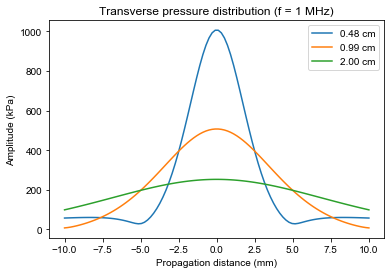

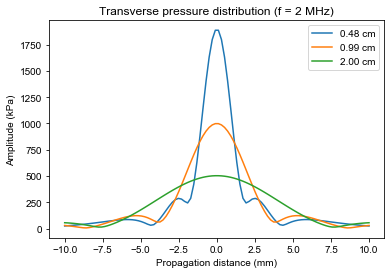

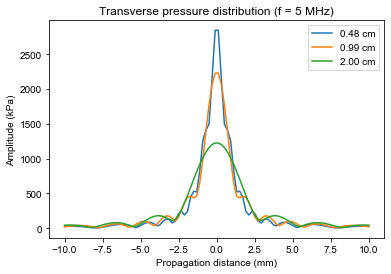

In [8]:
def plotTransverseAmpDist(Fdrive, x, z, amps, index):
    fig, ax = plt.subplots()
    ax.set_title(f'Transverse pressure distribution (f = {si_format(Fdrive)}Hz)')
    ax.set_xlabel('Propagation distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    for i in range(len(index)):
        lbl = f'{(z[index[i]] * 1e2):.2f} cm'
        ax.plot(x * 1e3, amps[:,index[i]] * 1e-3, c=f'C{i}', label=lbl)
    ax.legend()
    return fig

m = 1500
n = 100
x = np.linspace(-1e-2, 1e-2, n)
z = np.linspace(0, 0.02, n)  # m
index = [25, 50, 99]
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM(x, z, u_z, m, 'concentric')  # Pa
    plotTransverseAmpDist(Fdrive, x, z, amps, index)

As can be seen, there is a huge change in the pressure distribution along the fiber for the different US stimulation frequencies. This comes from the previous graphs for 2D acoustic field case. For the commonly used in our models 500 kHz frequency the pressure in the stimulated node can be a good characteristic of the whole pressure distribution as it is the distributions maximum value. This pressure is higher for the cases when the transducer is closer to the stimulating fiber and falls gradually with the radial distance. In case of 5 MHz stimulation frequency the pressure in the stimulated node can not be a reliable metric of the whole distribution as it is much more complex.

## Conclusions
- The ultrasound propagation along the neuron fiber is validated on the Yanagita et al. 2009 paper results.
- The NEURON model of the ultrasound propagation along the fiber is created.
- There are simulation parameters which can be measured during the in-vivo experiments.
- The strength-location curve obtained from the simulation data makes empirical sense.
- The strength-duration curve obtained from the simulation data makes empirical sense.

## References
- Yanagita T., Kundu T., Placko D., "Ultrasonic field modeling by distributed point source method for different transducer boundary conditions.", J. Acoust. Soc. Am. 2009 Nov; 126(5):2331-9. doi: 10.1121/1.3203307. https://bit.ly/2kiNwaS

